In [ ]:
import os
import pandas as pd
import numpy as np

# Notes:
- Here I want to generate new text, but training on headlines text.
- (Fitting the tokenizer only on the training, reduce the number of words on which the model is trained, yet we can use the test set to see what happens with not- seen words and how good is in replicating actual headlines)
- is possible to  fit the tokenizer on the training dataset using the oov_tokem = True to give an index for the the unknown words seen at test time
- Stacked lstm returns a list of the outputs (one for each timestamp)
- the last example shows how RNN and LSTM can be used at infinitive even if the sentence on which are trained have a fixed lenght.


# Next Word Prediction using Headlines

In [ ]:
curr_dir = '/Users/simoneboesso/Desktop/NextWordPrediction_LSTM/NewYorkTimes_comments/'
all_headlines = []
for filename in os.listdir(curr_dir):
    # Extracting only the headlines of the articles
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break
all_headlines = [h for h in all_headlines if h != "Unknown"]

# Training & Testing split

In [ ]:
from sklearn.model_selection import train_test_split
X_train = all_headlines

In [ ]:
import re
import string

''' This generates the words of our training set after preprecessing them:
- removing punctuation
- trasforming to lowerCase
'''
processed_X_train = []

for i in range(0, len(X_train)):
    headline = "".join(v for v in  X_train[i]   if v not in string.punctuation).lower()
    headline = headline.split()
    processed_X_train.append(headline)

print("X_train",len(processed_X_train))


X_train 829


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# Now i create the corrisponding number for each word
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(processed_X_train)
len(tokenizer.word_index)

2357

In [ ]:
tokenizer.fit_on_sequences(X_train)

In [ ]:
''' this create a sliding window from 2 to k ( with k the size of the sentence)
'''
input_sequences = []
for sentence in processed_X_train:
  # Converting each sentence using the created vocabulary
  tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
  # Now i want to create a sliding window for the training!
  # This is starting from 2 word sequences
  for i in range(1,len(tokenized_sentence),):
    input_sequences.append(tokenized_sentence[:i+1])

print("Train sequences",len(input_sequences))

Train sequences 4554


Now since i have sentences of different sizes i need to pad!

In [ ]:
# I find the max leng sentence in the training
max_len = max([len(x) for x in input_sequences])
print("max training sentence length",max_len)

from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_input_sequences = pad_sequences(input_sequences, maxlen = max_len, padding='pre')

max training sentence length 18


In [ ]:
padded_input_sequences.shape

(4554, 18)

# Creating the X and the Y

In [ ]:
X_train = padded_input_sequences[:,:-1] # all the columns except the last one!
y_train = padded_input_sequences[:,-1] # the last one is taken as the y

In [ ]:
# input size
LEN_SEQ = len(X_train[0])
LEN_SEQ

17

Convering using the to_categorical method!

In [ ]:
# Counting all the words in the training
total_words = len(tokenizer.word_index) + 1
total_words
# This is needed due to the embdedding layer needs the size of the vocabulary

2358

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=total_words)

In [ ]:
y_train.shape

(4554, 2358)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Embedding, LSTM, Dense,Dropout
EMBEDDING_SIZE = 10

model = Sequential()
model.add(Input(shape=(LEN_SEQ,)))  # Adding input layer with specified input shape
model.add(Embedding(total_words, EMBEDDING_SIZE)) #  (17,EMBEDDING_SIZE)
# Stacked LSTMs
#model.add(LSTM(100, return_sequences=True)) # This is returning the sequence of one output per input time step
model.add(LSTM(100)) # This is returning one output for all the input time steps
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax')) # This is returning a vector of size the corpus length
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 10)         │        23,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2358)           │       238,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,138 (1.17 MB)

 Trainable params: 306,138 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(model.get_weights()[0].shape) # Here I have a matrix with a vector representation for each encoded_word (Embedding layer)
print(model.get_weights()[1].shape)

(2358, 10)
(10, 400)


In [ ]:
result = model.fit(X_train,y_train,epochs=200)

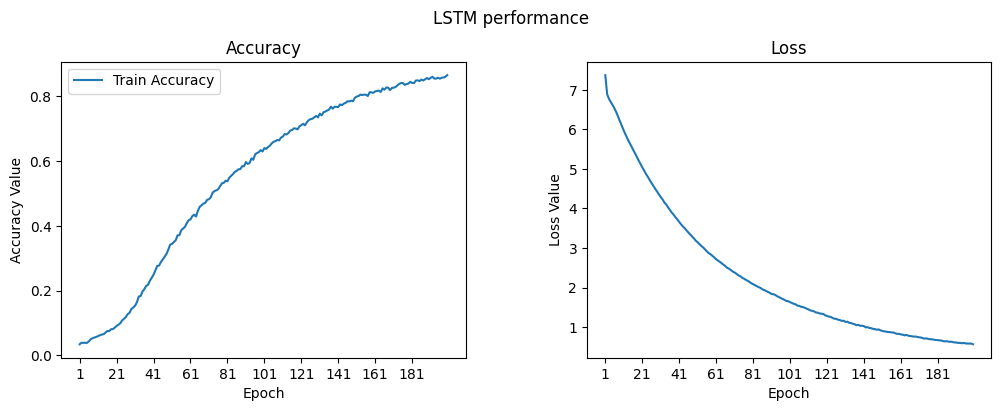

In [ ]:
import matplotlib.pylab as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('LSTM performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(result.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, result.history['accuracy'], label='Train Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 20))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, result.history['loss'], label='Train Loss')
ax2.set_xticks(np.arange(1, max_epoch, 20))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
plt.show()

# Let' use the model to generate text!
## Text generation task!

In [ ]:
import time
text = "trump"

for i in range(2):
  # tokenize
  token_text = tokenizer.texts_to_sequences([text])[0]
  # padding
  padded_token_text = pad_sequences([token_text], maxlen=max_len, padding='pre')
  # predict the index of the next word
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
trump is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
trump is perverse


In [ ]:
text = "do"

for i in range(30):
  # tokenize
  token_text = tokenizer.texts_to_sequences([text])[0]
  # padding
  padded_token_text = pad_sequences([token_text], maxlen=max_len, padding='pre')
  # predict the index of the next word
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
do you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
do you feel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
do you feel your school
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your school and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your school and teachers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your school and teachers welcome
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your school and teachers welcome both
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
do you feel your school and teachers welcome both conservative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
do you feel your school and teachers welcome both conservative and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
do you feel your school and teachers welcome both conservative and liberal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
do you feel your school and teachers welcome both conservative and liberal points
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step